# Challenge: Overfitting on Other Datasets

## Download data from `yfinance`

In [198]:
import pandas as pd
import numpy as np
import yfinance as yf

ticker = 'NVDA'
df = yf.download(ticker)
df

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
1999-01-22,0.037618,0.041016,0.048828,0.038802,0.043750,2714688000
1999-01-25,0.041559,0.045313,0.045833,0.041016,0.044271,510480000
1999-01-26,0.038334,0.041797,0.046745,0.041146,0.045833,343200000
1999-01-27,0.038215,0.041667,0.042969,0.039583,0.041927,244368000
1999-01-28,0.038095,0.041536,0.041927,0.041276,0.041667,227520000
...,...,...,...,...,...,...
2024-11-20,145.889999,145.889999,147.559998,142.729996,147.410004,309871700
2024-11-21,146.669998,146.669998,152.889999,140.699997,149.350006,400946600


## Preprocess the data

### Filter the date range

- Since 1 year ago at least

In [199]:
df = df.loc['2020-01-01':].copy()

### Create the target variable

#### Percentage change

- Percentage change on `Adj Close` for tomorrow

In [200]:
df['change_tomorrow'] = df['Adj Close'].pct_change(-1)
df.change_tomorrow = df.change_tomorrow * -1
df.change_tomorrow = df.change_tomorrow * 100

#### Remove rows with any missing data

In [201]:
df = df.dropna().copy()
df = df.droplevel('Ticker', axis=1)
df

Price,Adj Close,Close,High,Low,Open,Volume,change_tomorrow
Date,,,,,,,
2020-01-02,5.973122,5.997750,5.997750,5.918000,5.968750,237536000,-1.626637
2020-01-03,5.877516,5.901750,5.945750,5.852500,5.877500,205384000,0.417629
2020-01-06,5.902165,5.926500,5.931750,5.781750,5.808000,262636000,1.196184
2020-01-07,5.973620,5.998250,6.044250,5.909750,5.955000,314856000,0.187195
2020-01-08,5.984824,6.009500,6.051000,5.953750,5.994000,277108000,1.086341
...,...,...,...,...,...,...,...
2024-11-19,147.009995,147.009995,147.130005,140.990005,141.320007,227834900,-0.767698
2024-11-20,145.889999,145.889999,147.559998,142.729996,147.410004,309871700,0.531805
2024-11-21,146.669998,146.669998,152.889999,140.699997,149.350006,400946600,-3.325115


## Machine Learning modelling

### Feature selection

1. Target: which variable do you want to predict?
2. Explanatory: which variables will you use to calculate the prediction?

In [202]:
y = df.change_tomorrow
X = df.drop(columns='change_tomorrow')

### Train test split

In [203]:
from sklearn.model_selection import train_test_split

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.20, random_state=42, shuffle=False)

### Fit the model on train set

In [205]:
from sklearn.tree import DecisionTreeRegressor 

In [206]:
model_dt = DecisionTreeRegressor(max_depth=10, random_state=42)
model_dt.fit(X=X_train, y=y_train)

DecisionTreeRegressor(max_depth=10, random_state=42)

### Evaluate model

#### On test set

In [207]:
from sklearn.metrics import mean_squared_error 

In [208]:
y_pred_train = model_dt.predict(X_train)
y_pred_test  = model_dt.predict(X_test)

In [209]:
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test  = mean_squared_error(y_test , y_pred_test)

print(f"MSE train = {mse_train}\nMSE test  = {mse_test}")

MSE train = 8.494813163243132
MSE test  = 10.547081694530625


#### On train set

## Backtesting

In [210]:
from backtesting import Backtest, Strategy

### Create the `Strategy`

In [211]:
class Regression(Strategy):
    limit_buy = 0
    limit_sell = 0
    
    def init(self):
        self.model = DecisionTreeRegressor(max_depth=10, random_state=42)
        self.already_bought = False
        self.model.fit(X=X_train, y=y_train)
        print(f"limit buy {self.limit_buy}\nlimit sel {self.limit_sell}")

    def next(self):
        explanatory_today = self.data.df.iloc[[-1], :]
        forecast_tomorrow = self.model.predict(explanatory_today)[0]
        
        if forecast_tomorrow > self.limit_buy and self.already_bought == False:
            self.buy()
            self.already_bought = True
        elif forecast_tomorrow < self.limit_sell and self.already_bought == True:
            self.sell()
            self.already_bought = False
        else:
            pass

### Run the backtest on `test` data

In [212]:
bt_test = Backtest(X_test, Regression,
              cash=10000, commission=.002, exclusive_orders=True)

In [213]:
results = bt_test.run(limit_buy=0, limit_sell=-0)

df_results_test = results.to_frame(name='Values').loc[:'Return [%]']\
    .rename({'Values':'Out of Sample (Test)'}, axis=1)
df_results_test

limit buy 0
limit sel 0


,Out of Sample (Test)
Start,2023-12-04 00:00:00
End,2024-11-25 00:00:00
Duration,357 days 00:00:00
Exposure Time [%],89.878543
Equity Final [$],6124.921105
Equity Peak [$],11134.797294
Return [%],-38.750789


### Run the backtest on `train` data

In [214]:
bt_train = Backtest(X_train, Regression,
              cash=10000, commission=.002, exclusive_orders=True)

results = bt_train.run(limit_buy=0, limit_sell=-0)

df_results_train = results.to_frame(name='Values').loc[:'Return [%]']\
    .rename({'Values':'In Sample (Train)'}, axis=1)
df_results_train

limit buy 0
limit sel 0


,In Sample (Train)
Start,2020-01-02 00:00:00
End,2023-12-01 00:00:00
Duration,1429 days 00:00:00
Exposure Time [%],99.797366
Equity Final [$],182514.565482
Equity Peak [$],857272.240892
Return [%],1725.145655


### Compare both backtests

- HINT: Concatenate the previous `DataFrames`

In [215]:
df_results = pd.concat([df_results_train, df_results_test], axis=1)
df_results

,In Sample (Train),Out of Sample (Test)
Start,2020-01-02 00:00:00,2023-12-04 00:00:00
End,2023-12-01 00:00:00,2024-11-25 00:00:00
Duration,1429 days 00:00:00,357 days 00:00:00
Exposure Time [%],99.797366,89.878543
Equity Final [$],182514.565482,6124.921105
Equity Peak [$],857272.240892,11134.797294
Return [%],1725.145655,-38.750789


#### Plot both backtest reports

In [216]:
bt_test.plot(filename="reports_backtesting/9c_test.html")
bt_train.plot(filename="reports_backtesting/9c_train.html")

Row(id='14655', ...)

In [217]:
## how did the stock do itself, so what if I had bought on day 0 and sold on last day?

open_train = X_train.iloc[0,:].Open
close_train = X_train.iloc[-1,:].Close

open_test = X_test.iloc[0,:].Open
close_test = X_test.iloc[-1,:].Close

increase_train = (close_train-open_train)/open_train*100
increase_test  = (close_test-open_test)/open_test*100

print(f"Train data:\n\tfrom: {open_train}\n\tto: {close_train}\n\tIncrease: {increase_train}%\n")
print(f"Test data:\n\tfrom: {open_test}\n\tto: {close_test}\n\tIncrease: {increase_test}%")

Train data:
	from: 5.96875
	to: 46.76499938964844
	Increase: 683.4973719731676%

Test data:
	from: 46.07699966430664
	to: 136.02000427246094
	Increase: 195.20152193813146%


In [218]:
import matplotlib.pyplot as plt

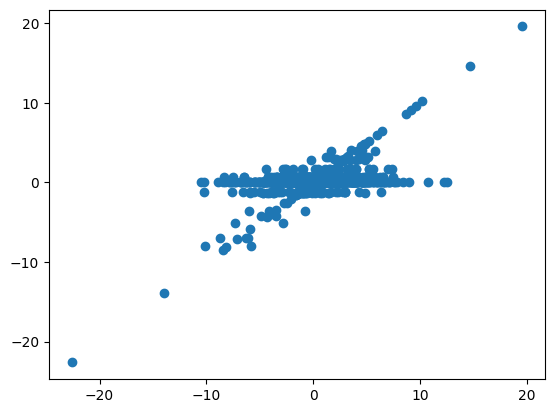

In [219]:
plt.scatter(y_train, y_pred_train)

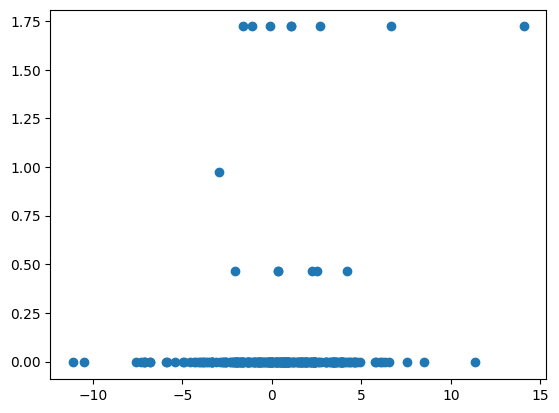

In [220]:
plt.scatter(y_test, y_pred_test)

## How to solve the overfitting problem?

> Walk Forward Validation as a realistic approach to backtesting.

Next tutorial → [Walk Forward Validation]()

![](<src/10_Table_Validation Methods.png>)